<a href="https://colab.research.google.com/github/abdulrahimq/audio-to-stress/blob/main/wav_to_vec_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U openai-whisper
from whisper import audio
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=6ec0044162ad8dacae29f196f0c9018cfb10062db0bc98d3bccd90bfb17aebc3
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [3]:
df = pd.read_csv("/content/Copy_of_South Levantine_wiktionary_ipa_3.csv")

In [4]:
df.info()
df.columns
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782 entries, 0 to 2781
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   soundVec    0 non-null      float64
 1   ipa         2782 non-null   object 
 2   syllables   0 non-null      float64
 3   stress      0 non-null      float64
 4   audio_urls  2656 non-null   object 
dtypes: float64(3), object(2)
memory usage: 108.8+ KB


(2782, 5)

In [5]:
df.head(20)

,soundVec,ipa,syllables,stress,audio_urls
0,NaN,ʔāḵir<p:ʔæː.xɪr><p:ʔaː.xɪr>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
1,NaN,ʔāḵre<p:ˈʔæːx.re> ʔāḵra<p:ˈʔæːx.ra>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2,NaN,ʔāḏār<p:ʔaˈðˤɑːrˤ><p:ʔaˈzˤɑːrˤ>,NaN,NaN,NaN
3,NaN,ʔāsef<p:ˈʔæː.sɪf>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
4,NaN,ʔāsya<p:ˈʔæːs.ja>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
5,NaN,ʔālāf<p:ʔaˈlæːf>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
6,NaN,ʔāle<p:ˈʔæː.le> ʔāla<p:ˈʔæː.la>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
7,NaN,ʔāman<p:ˈʔæː.man>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
8,NaN,ʔānas<p:ˈʔæː.nas>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
9,NaN,ʔā<p:ʔɑː>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [6]:
df['ipa']

,ipa
0,ʔāḵir<p:ʔæː.xɪr><p:ʔaː.xɪr>
1,ʔāḵre<p:ˈʔæːx.re> ʔāḵra<p:ˈʔæːx.ra>
2,ʔāḏār<p:ʔaˈðˤɑːrˤ><p:ʔaˈzˤɑːrˤ>
3,ʔāsef<p:ˈʔæː.sɪf>
4,ʔāsya<p:ˈʔæːs.ja>
...,...
2777,yahūd<p:jaˈhuːd>
2778,yahūdi<p:jaˈhuː.di>
2779,yōm<p:joːm>
2780,gīm<p:ɡiːm>


In [7]:
def clean_transcription(dataframe):
  """
  A function that takes the dataframe and cleans the ipa column.
  first holds all the strings between '<' and '>', deletes everything else, then
  removes every occurence of 'p',':', and '<'/'>' from the result, returning a list of
  raw ipa transcriptions separated by ','
  """
  dictionary = []
  dictionary.append(dataframe)
  counter = 0
  for i in range(len(dataframe['ipa'])):
    r = re.findall("<.*?>", dataframe.loc[i, 'ipa'])
    for word in range(len(r)):
        r[word] = re.sub("[p:><]", "", r[word])
    if len(r) <= 1:
      dataframe.loc[i, 'ipa'] = "".join(r)
    else:
        dataframe.loc[i,'ipa'] = r[0]
        for word in range(len(r[1:])):
          dictionary.append(pd.DataFrame({'soundVec':dataframe.loc[i,'soundVec'], 'ipa':r[word + 1],
                        'syllables':dataframe.loc[i,'syllables'], 'stress':dataframe.loc[i,'stress'],
                        'audio_urls':dataframe.loc[i,'audio_urls']}, index=[len(dataframe) + counter]))
          counter+=1
  dataframe = pd.concat(dictionary)
  return dataframe

In [8]:
df = clean_transcription(df)

In [9]:
print(df.shape)
df.loc[2782:2800,]


(3696, 5)


,soundVec,ipa,syllables,stress,audio_urls
2782,NaN,ʔaː.xɪr,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2783,NaN,ˈʔæːx.ra,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2784,NaN,ʔaˈzˤɑːrˤ,NaN,NaN,NaN
2785,NaN,ˈʔæː.la,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2786,NaN,ˈʔat.lad͡ʒ,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2787,NaN,ˈʔas.sar,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2788,NaN,ˈʔad.d͡ʒal,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2789,NaN,ˈʔad͡ʒ.na.bi,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2790,NaN,ˈʔaħ.rad͡ʒ,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2791,NaN,ʔarˈɡiː.la,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [10]:
df.head(20)

,soundVec,ipa,syllables,stress,audio_urls
0,NaN,ʔæː.xɪr,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
1,NaN,ˈʔæːx.re,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2,NaN,ʔaˈðˤɑːrˤ,NaN,NaN,NaN
3,NaN,ˈʔæː.sɪf,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
4,NaN,ˈʔæːs.ja,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
5,NaN,ʔaˈlæːf,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
6,NaN,ˈʔæː.le,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
7,NaN,ˈʔæː.man,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
8,NaN,ˈʔæː.nas,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
9,NaN,ʔɑː,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [11]:
def populate(row, column, value, dataframe):
  """
  it simply rewrites this location in the dataframe with the value.
  """
  dataframe.loc[row, column] = value

In [12]:
def count_syllables(dataframe):
  """
  a function which takes the dataframe and for each transcription,
  counts the syllables indicated in the ipa. for the transcription,
  it counts each occurence of '.' and any occurence of 'ˈ' (note that this is NOT an apostrophe?) that
  is preceded by a word character. when there is more than one transcription, we use
  the first one by default.
  """
  for i in range(len(dataframe['ipa'])):
    s = dataframe.loc[i, 'ipa']
    if len(re.findall(",", s)) > 0:
      s = re.split(", ", s)[0]
    syllables =len(re.findall(r"\wˈ", s)) + len(re.findall(r"\.", s)) + 1
    populate(i, 'syllables', syllables, dataframe)


In [13]:
count_syllables(df)
df.head(20)

,soundVec,ipa,syllables,stress,audio_urls
0,NaN,ʔæː.xɪr,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
1,NaN,ˈʔæːx.re,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2,NaN,ʔaˈðˤɑːrˤ,2.0,NaN,NaN
3,NaN,ˈʔæː.sɪf,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
4,NaN,ˈʔæːs.ja,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
5,NaN,ʔaˈlæːf,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
6,NaN,ˈʔæː.le,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
7,NaN,ˈʔæː.man,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
8,NaN,ˈʔæː.nas,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
9,NaN,ʔɑː,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [14]:
df.tail(20)

,soundVec,ipa,syllables,stress,audio_urls
3676,NaN,qBedouin,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3677,NaN,ˈwaz.za,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3678,NaN,ˈwsæː.da,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3679,NaN,wɑ.tˤɑˈnij.ja,4.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3680,NaN,wɑˈzˤiː.fa,3.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3681,NaN,qUrban,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3682,NaN,qBedouin,1.0,NaN,NaN
3683,NaN,qUrban,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3684,NaN,ˈwi.ɡɪʕ,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3685,NaN,qBedouin,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [15]:

def find_stress_location(dataframe):
  """
  takes each transcription in the dataframe and identifies where the stress is marked.
  for each transcription, we check first if there is stress (the presence of 'ˈ' indicates stress),
  if so, the function counts the number of occurences of '.' before the first appearance of 'ˈ' to
  make the determination of on which syllable the stress is located. If there is more than one transcription
  fot the word, the first one is used by default. We assume there is at most one stress possible in a word.
  """
  stress = 0
  for i in range(len(dataframe['ipa'])):
    s = dataframe.loc[i,'ipa']
    if len(re.findall(",", s)) > 0:
      s = re.split(", ", s)[0]
    if len(re.findall("ˈ", s)) == 0:
      continue
    if len(re.findall(r"\wˈ", s)) == 1:
      r = re.findall(r"\..*ˈ", s)
      if len(r) == 0:
        stress = 2
      else:
        stress = len(re.findall(r"\.",r[0])) + 2
    else:
      stress = 1
    populate(i, 'stress', stress, dataframe)

In [16]:
find_stress_location(df)
df.head(20)





,soundVec,ipa,syllables,stress,audio_urls
0,NaN,ʔæː.xɪr,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
1,NaN,ˈʔæːx.re,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
2,NaN,ʔaˈðˤɑːrˤ,2.0,2.0,NaN
3,NaN,ˈʔæː.sɪf,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
4,NaN,ˈʔæːs.ja,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
5,NaN,ʔaˈlæːf,2.0,2.0,https://upload.wikimedia.org/wikipedia/commons...
6,NaN,ˈʔæː.le,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
7,NaN,ˈʔæː.man,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
8,NaN,ˈʔæː.nas,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
9,NaN,ʔɑː,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [17]:
df.tail(20)

,soundVec,ipa,syllables,stress,audio_urls
3676,NaN,qBedouin,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3677,NaN,ˈwaz.za,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
3678,NaN,ˈwsæː.da,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
3679,NaN,wɑ.tˤɑˈnij.ja,4.0,3.0,https://upload.wikimedia.org/wikipedia/commons...
3680,NaN,wɑˈzˤiː.fa,3.0,2.0,https://upload.wikimedia.org/wikipedia/commons...
3681,NaN,qUrban,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3682,NaN,qBedouin,1.0,NaN,NaN
3683,NaN,qUrban,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3684,NaN,ˈwi.ɡɪʕ,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
3685,NaN,qBedouin,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [18]:
def mark_mono_syllables(dataframe):

  """
  as per a linguistic observation, this function marks every monosyllabic Arabic word in the list with a stress.
  the stress is assumed to be on the first (and only) syllable.
  """
  for i in range (len(dataframe['syllables'])):
    if (dataframe.loc[i, 'syllables'] == 1 and dataframe.loc[i, 'ipa'] != 'qBedouin' and dataframe.loc[i,'ipa'] != 'qUrban'):
      populate(i, 'stress', 1, dataframe)


In [19]:
mark_mono_syllables(df)


In [20]:
df.head(20)

,soundVec,ipa,syllables,stress,audio_urls
0,NaN,ʔæː.xɪr,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
1,NaN,ˈʔæːx.re,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
2,NaN,ʔaˈðˤɑːrˤ,2.0,2.0,NaN
3,NaN,ˈʔæː.sɪf,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
4,NaN,ˈʔæːs.ja,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
5,NaN,ʔaˈlæːf,2.0,2.0,https://upload.wikimedia.org/wikipedia/commons...
6,NaN,ˈʔæː.le,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
7,NaN,ˈʔæː.man,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
8,NaN,ˈʔæː.nas,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
9,NaN,ʔɑː,1.0,1.0,https://upload.wikimedia.org/wikipedia/commons...


In [21]:
df.tail(20)

,soundVec,ipa,syllables,stress,audio_urls
3676,NaN,qBedouin,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3677,NaN,ˈwaz.za,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
3678,NaN,ˈwsæː.da,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
3679,NaN,wɑ.tˤɑˈnij.ja,4.0,3.0,https://upload.wikimedia.org/wikipedia/commons...
3680,NaN,wɑˈzˤiː.fa,3.0,2.0,https://upload.wikimedia.org/wikipedia/commons...
3681,NaN,qUrban,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3682,NaN,qBedouin,1.0,NaN,NaN
3683,NaN,qUrban,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3684,NaN,ˈwi.ɡɪʕ,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
3685,NaN,qBedouin,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [22]:
def generate_data_dict(dataframe):
  """
  takes the dataframe and generates the numerical representation of
  the sound for each word. currently, only the length of the resulting vector
  is saved to the dataframe.
  """
  v = {'soundVecs':[], 'stress':[], 'ipa':[]}
  for i in range(len(dataframe['soundVec'])):
    s = dataframe.loc[i, 'audio_urls']
    if type(s) == float or dataframe.loc[i,'stress'] == np.nan:
      continue
    try:
      v['soundVecs'].append(audio.load_audio(s))
      v['stress'].append(dataframe.loc[i,'stress'])
      v['ipa'].append(dataframe.loc[i, 'ipa'])
    except Exception:
      continue
  return v


In [87]:
data_dictionary = generate_data_dict(df)
import pickle
from google.colab import files
with open('data_dictionary.pkl', 'wb') as f:
    pickle.dump(data_dictionary, f)
files.download('data_dictionary.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
len(data_dictionary['soundVecs'])

16

In [26]:
with open('/content/data_dictionary.pkl', 'rb') as f:
  data_dictionary = pickle.load(f)

In [28]:
print(len(data_dictionary['soundVecs']))
print(len(data_dictionary['stress']))
print(len(data_dictionary['ipa']))

3128
3128
3128


In [32]:
def count_lengths_of_vectors(list_of_vecs):
  '''
  it creates a vector of lengths of every element of this list which is
  a vector of some variable length.
  '''
  length_vec = np.ndarray((len(list_of_vecs),))
  for vector in range(len(list_of_vecs)):
    length_vec[vector] = len(list_of_vecs[vector])
  return length_vec


In [42]:
vecLengths = count_lengths_of_vectors(data_dictionary['soundVecs'])

In [34]:
def compute_vec_stats(vector):
  """
  computes and prints a few basic statistics on the distribution in
  the numerical vector provided. also displays a plot of the values.
  """
  print("Shape: ", vector.shape)
  mean_vector_length = np.nanmean(vector)
  print("mean vector length: ", mean_vector_length)
  median_vector_length = np.nanmedian(vector)
  print("median vector length: ", median_vector_length)
  maximum_vector = np.nanpercentile(vector, 100)
  minimum_vector = np.nanpercentile(vector, 0)
  print("maximum vector: ", maximum_vector)
  print("minimum vector: ", minimum_vector)
  fig, axes = plt.subplots()
  axes.plot(vector, 'ko')


Shape:  (3128,)
mean vector length:  18625.86381074169
median vector length:  18219.0
maximum vector:  33237.0
minimum vector:  11392.0


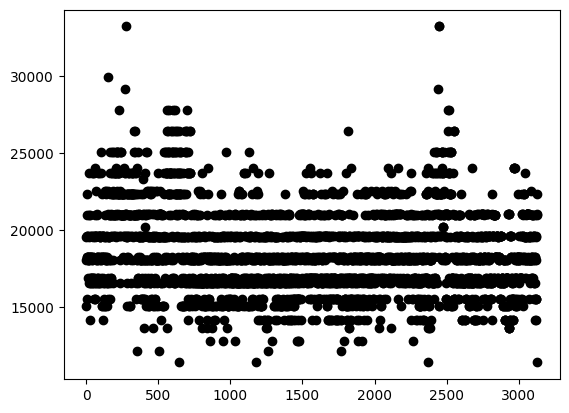

In [43]:
compute_vec_stats(vecLengths)

In [41]:
data_dictionary['soundVecs'][13] = data_dictionary['soundVecs'][14]
data_dictionary['stress'][13] = data_dictionary['stress'][14]
data_dictionary['ipa'][13] = data_dictionary['ipa'][14]


In [45]:
pad_size = 27000

In [54]:
def generate_padded_audio_vectors(data, dictionary, size):
  """
  takes in the data frame and returns an array representing the audio vectors,
  each of the size specified. The audio package from whisper is used to generate, and pad or trim
  the vectors.
  """
  for i in range(len(data)):
    try:
      data[i] = audio.pad_or_trim(dictionary['soundVecs'][i], size)
    except Exception:
      continue

def generate_data(dictionary, size):
  '''
  takes the dictionary and generates a fixed length matrix which will be used
  for machine learning.
  '''
  data = {'X':np.ndarray((len(dictionary['soundVecs']), size)), 'Y':np.ndarray((len(dictionary['stress']),1))}
  generate_padded_audio_vectors(data['X'], dictionary, size)
  for i in range(len(data['Y'])):
    data['Y'][i] = dictionary['stress'][i]
  return data





In [55]:
data = generate_data(data_dictionary, pad_size)

In [77]:

print(data['X'].shape)
print(data['Y'].shape)

(3128, 27000)
(3128, 1)


In [48]:
def visualize(vector):
  """
  takes the vector, which by assumption is of an audio representation,
  then displays its wave information, along with its spectrogram.
  """
  fig, axes1 = plt.subplots()
  fig, axes2 = plt.subplots()
  axes1.plot(vector, '-')
  axes2.specgram(vector)

[-3.05175781e-05 -3.05175781e-05  6.10351562e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
(27000,)
[1.]
ˈlaħ.zˤɑ


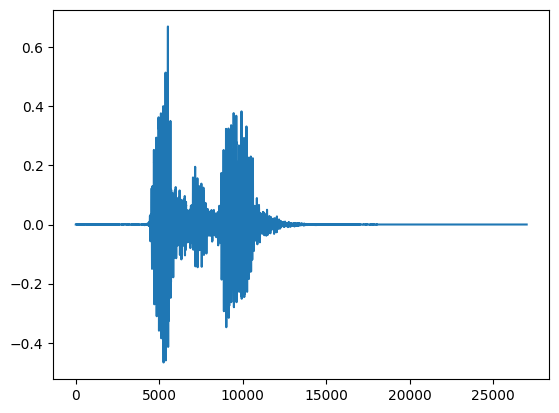

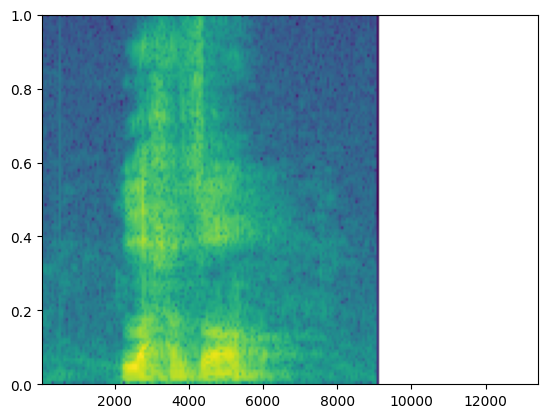

In [76]:
i = 3003
print(data['X'][i])
print(data['X'][i].shape)
print(data['Y'][i])
print(data_dictionary['ipa'][i])
visualize(data['X'][i])

In [107]:
print(np.where(np.isnan(data['X'])))
print(np.where(np.isnan(data['Y'])))
data_dictionary['stress'][82]
data_dictionary['ipa'][174]

(array([], dtype=int64), array([], dtype=int64))
(array([  82,  174,  180,  202,  210,  224,  309,  709,  788,  789,  904,
       1106, 1128, 1172, 1236, 1284, 1301, 1302, 1303, 1329, 1368, 1401,
       1475, 1480, 1488, 1748, 1817, 1954, 2010, 2021, 2202, 2204, 2205,
       2210, 2211, 2246, 2400, 2402, 2407, 2411, 2423, 2429, 2432, 2434,
       2436, 2438, 2451, 2453, 2456, 2458, 2462, 2464, 2466, 2468, 2479,
       2481, 2487, 2489, 2490, 2492, 2494, 2496, 2510, 2512, 2523, 2525,
       2526, 2528, 2529, 2531, 2532, 2534, 2548, 2550, 2605, 2607, 2610,
       2612, 2613, 2615, 2617, 2619, 2621, 2624, 2626, 2635, 2637, 2647,
       2649, 2650, 2652, 2654, 2657, 2659, 2667, 2669, 2682, 2684, 2685,
       2687, 2688, 2690, 2691, 2693, 2700, 2702, 2703, 2705, 2717, 2719,
       2723, 2725, 2727, 2728, 2730, 2739, 2741, 2747, 2749, 2751, 2753,
       2767, 2769, 2778, 2780, 2785, 2787, 2790, 2792, 2798, 2800, 2815,
       2817, 2818, 2820, 2821, 2823, 2824, 2826, 2827, 2829, 2830, 2832,
 

'ʔi.b(ɪ)n'

In [108]:
def mark_words_with_no_stress(data):
  '''
  under the current working assumption, we will label any unstressed word,
  which is NOT monosyllabic, as having 0 stress.
  '''
  for i in range(len(data)):
    if np.isnan(data[i]):
      data[i] = 0


In [109]:
mark_words_with_no_stress(data['Y'])

In [110]:
X_train, X_test, Y_train, Y_test = train_test_split(data['X'], data['Y'], test_size=.2)

In [113]:
X_test, X_dev, Y_test, Y_dev = train_test_split(X_test, Y_test, test_size=.5)

In [111]:
np.where(np.isnan(Y_train))


(array([], dtype=int64), array([], dtype=int64))

#Machine learning Stage










In [79]:
from sklearn.linear_model import LogisticRegression

In [112]:
LR = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs')
LR.fit(X_train, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [121]:
print(LR.classes_)
print(LR.coef_)
print(LR.coef_.shape)
print(LR.n_features_in_)
print(LR.n_iter_)


[0. 1. 2. 3. 4.]
[[ 9.11171833e-04  1.14601822e-03  1.06718513e-03 ... -4.17509980e-05
  -5.91183400e-05 -6.27498514e-05]
 [ 2.49020231e-03  1.56956246e-03  1.45758032e-03 ...  2.46772705e-04
   3.59329766e-04  3.75363519e-04]
 [-2.79747347e-03 -2.22697199e-03 -2.23348848e-03 ... -1.33532986e-04
  -1.97807798e-04 -2.07214237e-04]
 [-5.84140886e-04 -4.80026217e-04 -2.68922389e-04 ... -3.52053878e-05
  -5.15022268e-05 -5.26286060e-05]
 [-1.97597885e-05 -8.58247867e-06 -2.23545874e-05 ... -3.62833330e-05
  -5.09014016e-05 -5.27708242e-05]]
(5, 27000)
27000
[61]


In [124]:
probs = LR.predict_proba(X_dev)
stress0, stress1, stress2, stress3, stress4 = probs[:,0],probs[:,1],probs[:,2],probs[:,3],probs[:,4]
X_dev_predictions = LR.predict(X_dev)
d = {'stress0':stress0, 'stress1':stress1, 'stress2':stress2, 'stress3':stress3, 'stress4':stress4,
     'X_dev predictions':X_dev_predictions, 'True X_dev value':Y_dev[:,0]}
results_analysis = pd.DataFrame(d,index=list(range(len(X_dev))))

In [128]:
print('Score: ', LR.score(X_dev, Y_dev))
results_analysis.head(20)


Score:  0.5718849840255591


,stress0,stress1,stress2,stress3,stress4,X_dev predictions,True X_dev value
0,0.000216,0.999715,4.418520e-05,2.434460e-05,8.946474e-07,1.0,1.0
1,0.000004,0.004263,9.956730e-01,5.924554e-05,9.051984e-07,2.0,1.0
2,0.012094,0.768848,1.957359e-01,2.325795e-02,6.453375e-05,1.0,1.0
3,0.270183,0.673455,4.837114e-02,7.914500e-03,7.669849e-05,1.0,0.0
4,0.014080,0.190415,7.907807e-01,4.687560e-03,3.677474e-05,2.0,2.0
5,0.002330,0.868536,2.132608e-02,1.077568e-01,5.147618e-05,1.0,1.0
6,0.002241,0.943421,5.287406e-02,1.446406e-03,1.764873e-05,1.0,0.0
7,0.031959,0.920739,4.406897e-02,3.191638e-03,4.164388e-05,1.0,2.0
8,0.043443,0.755359,1.964401e-01,4.682216e-03,7.564716e-05,1.0,1.0
9,0.726662,0.247428,2.428119e-02,1.601460e-03,2.697830e-05,0.0,1.0


In [129]:
results_analysis.tail(20)

,stress0,stress1,stress2,stress3,stress4,X_dev predictions,True X_dev value
293,4.009377e-03,0.931739,0.060000,0.004223,2.894389e-05,1.0,1.0
294,5.880808e-03,0.988518,0.004925,0.000665,1.147666e-05,1.0,1.0
295,4.762148e-02,0.637487,0.296359,0.018417,1.159704e-04,1.0,2.0
296,2.270491e-03,0.983557,0.013448,0.000715,9.889801e-06,1.0,1.0
297,2.002690e-03,0.452573,0.543850,0.001554,2.108851e-05,2.0,1.0
298,5.107277e-07,0.000094,0.994259,0.005646,3.900931e-07,2.0,1.0
299,4.843038e-04,0.975570,0.023890,0.000051,4.185338e-06,1.0,1.0
300,1.906733e-02,0.937808,0.043024,0.000089,1.197873e-05,1.0,1.0
301,1.028640e-03,0.994659,0.002329,0.001977,6.398744e-06,1.0,1.0
302,1.162957e-04,0.999523,0.000343,0.000017,6.402007e-07,1.0,1.0
